# Memory data analysis summary:
### By: Matthew Oberhardt

## Startup:

In [153]:
## Startup:

import synapseclient
from synapseclient import Project, Folder, File
import pandas as pd
import json
import pickle
import re
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import numpy as np
import seaborn as sns
import os
from numpy import nan
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import ranksums
%load_ext autoreload
%autoreload 2
%matplotlib inline  


## set options ##

sns.set(style="darkgrid", color_codes=True, font_scale=1.5)

# so i can see all rows of dfs
pd.set_option('display.max_columns', 500)

# so that i can print as many lines as i want
np.set_printoptions(threshold='nan') 

## import my memorytools module ##

import memorytools as mt


# Load up the memory & demographic data:

# initialize environment:
synuser = os.environ['SYNAPSE_USER']
synpass = os.environ['SYNAPSE_PASS']
mt.loadSynapseRecordsFromScratch = False
syn, memory, memorysyn, filePaths, demographics, demosyn, data = mt.create_memory_environment(synuser, synpass)
data = mt.filter_data_for_popular_phones(data)

# pull out features from games:
fromFile = True#False
toSave = False#True
data = mt.add_memory_game_features_to_data(filePaths, data, fromFile = fromFile, toSave=toSave, outFileName='memory_data_with_features.p')

# add memory composite features:
data = mt.add_composite_features_to_data(data)


from sklearn import linear_model
import sklearn
import sklearn.linear_model
import sklearn.cross_validation
import sklearn.tree
import sklearn.ensemble
import numpy as np
from sklearn.utils.validation import check_consistent_length, _num_samples
import sklearn.preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# load feature categories
fcats = mt.define_feature_categories()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Welcome, Matthew Oberhardt!
(phones are now filtered for only the most popular ones)
memory features loaded from file: memory_data_with_features.p (input data was ignored)
Note that nyearsOffMeds = nyearsParkinsons - nyearsOnMeds
Note that nyearsOffMeds = nyearsParkinsons - nyearsOnMeds


In [154]:
from memorytools import *
agecutoff = 45

## visualize the data as a whole:

# Parkinsons patients: 322
# game records, Parkinsons 6164
# non-Parkinsons patients: 525
# game records, non-Parkinsons 1690


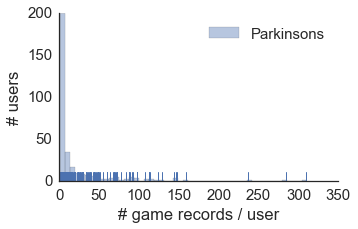

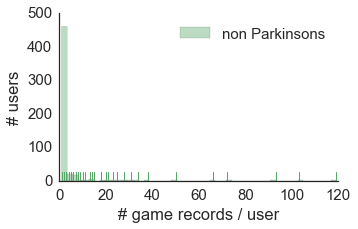

In [155]:

sns.set(style="white", font_scale=1.5)

Pgroups = data.groupby('hasParkinsons')
dp = Pgroups.get_group(True)
dnp = Pgroups.get_group(False)

# plot dists:
distP = dp['healthCode'].value_counts()
distNP = dnp['healthCode'].value_counts()

#array, bin_edges = np.histogram(data['healthCode'].value_counts(), bins=20)
#plt.figure()
#ax1 = sns.distplot(distP, kde=False, label='Parkinsons', bins=20)
#ax2 = sns.distplot(distNP, kde=False, label='non Parkinsons', bins=20)
#plt.xlabel('Users')
#plt.ylabel('# Game records per user')
#plt.legend(loc=4)

figsizes = (5,3)

plt.figure(figsize=figsizes)
ax1 = sns.distplot(distP, kde=False, rug=True, hist=True, label='Parkinsons', color='b')
#ax1 = sns.distplot(distP, kde=True, kde_kws={"shade": True}, rug=True, hist=False, label='Parkinsons', color='b')
plt.xlabel('# game records / user')
plt.ylabel('# users')
plt.legend(loc=1)
#ax1.set_yscale('log')
sns.despine()

plt.figure(figsize=figsizes)
ax2 = sns.distplot(distNP, kde=False, rug=True, hist=True, label='non Parkinsons', color='g')
#ax2 = sns.distplot(distNP, kde=True, kde_kws={"shade": True}, rug=True, hist=False, label='non Parkinsons', color='g')ax2 = sns.distplot(distNP, kde=True, kde_kws={"shade": True}, rug=True, hist=False, label='non Parkinsons', color='g')
plt.xlabel('# game records / user')
plt.ylabel('# users')
plt.legend(loc=1)
#ax2.set_yscale('log')
sns.despine()

print '# Parkinson''s patients:', len(distP)
print '# game records, Parkinson''s', distP.sum()

print '# non-Parkinson''s patients:', len(distNP)
print '# game records, non-Parkinson''s', distNP.sum()

sns.set(style="darkgrid", color_codes=True, font_scale=1.5)

## Predicting whether users have Parkinson's disease using mPower memory game data:

### Using mean values per patient, logistic regression. varying feature sets

In [156]:
# setup:
featureToMean = ['healthCode'] # don't need to also exclude - this step takes care of that too.
MLexcludecols = []
labelcol = 'hasParkinsons'

features_main = ['game_score', '9_numsuccesses', '9_meandist', '9_successful', '9_gamescore', '9_latency', 
               '9_firstdist', '9_meanDt', '9_meansuccessfuldist', '16_firstdist', '16_meandist', '16_numsuccesses', 
               '16_gamescore', '16_latency', '16_successful', '16_meanDt', '16_meansuccessfuldist', 'hasParkinsons',
               'healthCode']    

#####
Predicting Parkinson's using only demographic features:
Somewhat predictive, since the demographics are skewed
in the data. Note, there are no features from the memory game
included here, so this shouldn't be predictive at all.
Therefore, these features are problematic, and they are
excluded from the other analyses.
#####


Features converted to numbers:
['gender', 'education']
dropped 0 rows to remove all nas from data
# positive in labelcol:  302.0
# total in labelcol:  445
na rows have been dropped (if there were any)


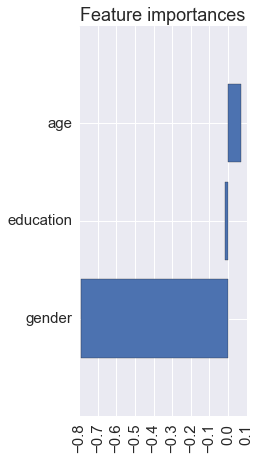

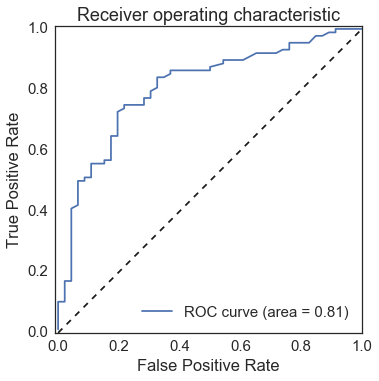

In [157]:
print '#####'
print 'Predicting Parkinson\'s using only demographic features:'
print 'Somewhat predictive, since the demographics are skewed'
print 'in the data. Note, there are no features from the memory game'
print 'included here, so this shouldn\'t be predictive at all.'
print 'Therefore, these features are problematic, and they are' 
print 'excluded from the other analyses.'
print '#####'
print '\n'
features = ['age', 'gender', 'education', 'hasParkinsons', 'healthCode']

datasample = data[data['age']>agecutoff]
outs = mt.build_ML_model(datasample, features, labelcol=labelcol, toPlot=[0,1,1], toPrint=False, MLexcludecols=MLexcludecols, modelType='logisticregression', featureToMean=featureToMean)


#####
Predicting Parkinson's with all main features:
#####


Features converted to numbers:
[]
dropped 256 rows to remove all nas from data
# positive in labelcol:  290.0
# total in labelcol:  430
na rows have been dropped (if there were any)


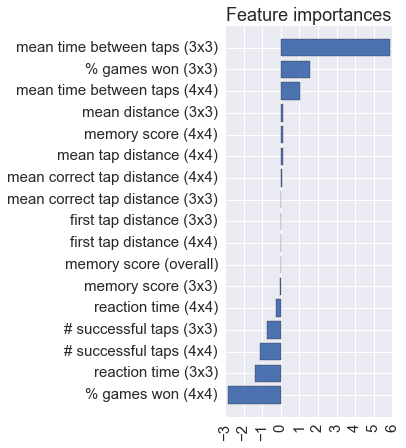

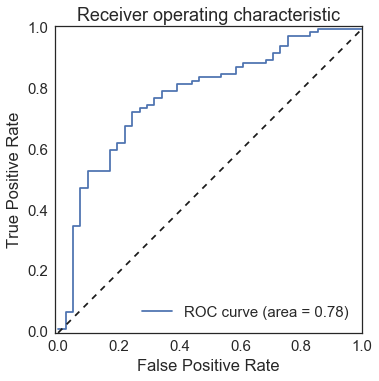

In [158]:
print '#####'
print 'Predicting Parkinson\'s with all main features:'
print '#####'
print '\n'
features = list(features_main)
datasample = data[data['age']>agecutoff]
outs = mt.build_ML_model(datasample, features, labelcol=labelcol, toPlot=[0,1,1], toPrint=False, MLexcludecols=MLexcludecols, modelType='logisticregression', featureToMean=featureToMean)


#####
Predicting Parkinson's after removing % games won features:
(these are of dubious quality)
(this makes nearly no difference)
#####


Features converted to numbers:
[]
dropped 256 rows to remove all nas from data
# positive in labelcol:  290.0
# total in labelcol:  430
na rows have been dropped (if there were any)


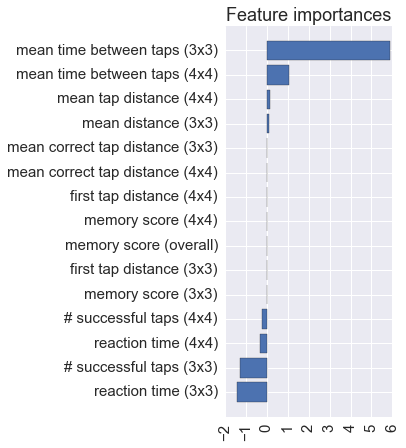

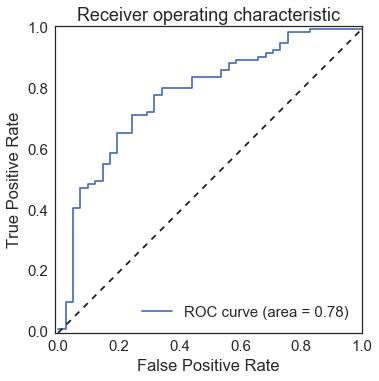

In [159]:
print '#####'
print 'Predicting Parkinson\'s after removing % games won features:'
print '(these are of dubious quality)'
print '(this makes nearly no difference)'
print '#####'
print '\n'
features = list(features_main)
features.remove('9_successful')
features.remove('16_successful')
datasample = data[data['age']>agecutoff]
outs = mt.build_ML_model(datasample, features, labelcol=labelcol, toPlot=[0,1,1], toPrint=False, MLexcludecols=MLexcludecols, modelType='logisticregression', featureToMean=featureToMean)

#####
Predicting Parkinson's after removing time delay features:
(ruins signal)
#####


Features converted to numbers:
[]
dropped 256 rows to remove all nas from data
# positive in labelcol:  290.0
# total in labelcol:  430
na rows have been dropped (if there were any)


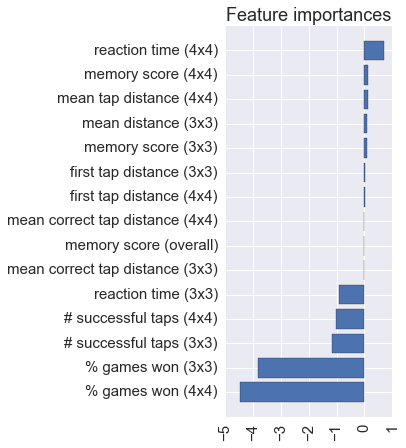

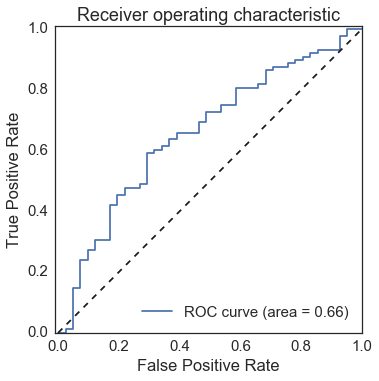

In [160]:
print '#####'
print 'Predicting Parkinson\'s after removing time delay features:'
print '(ruins signal)'
print '#####'
print '\n'
features = list(features_main)
features.remove('9_meanDt')
features.remove('16_meanDt')
datasample = data[data['age']>agecutoff]
outs = mt.build_ML_model(datasample, features, labelcol=labelcol, toPlot=[0,1,1], toPrint=False, MLexcludecols=MLexcludecols, modelType='logisticregression', featureToMean=featureToMean)


#####
Predicting Parkinson's after removing game score features:
(no big difference)
#####


Features converted to numbers:
[]
dropped 256 rows to remove all nas from data
# positive in labelcol:  290.0
# total in labelcol:  430
na rows have been dropped (if there were any)


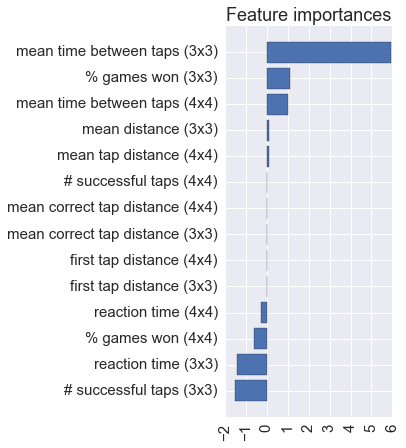

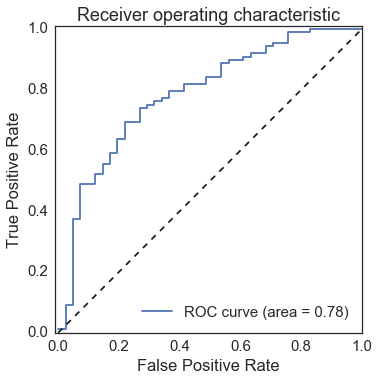

In [161]:
print '#####'
print 'Predicting Parkinson\'s after removing game score features:'
print '(no big difference)'
print '#####'
print '\n'
features = list(features_main)
features.remove('9_gamescore')
features.remove('16_gamescore')
features.remove('game_score')
datasample = data[data['age']>agecutoff]
outs = mt.build_ML_model(datasample, features, labelcol=labelcol, toPlot=[0,1,1], toPrint=False, MLexcludecols=MLexcludecols, modelType='logisticregression', featureToMean=featureToMean)


## One sample per patient, run as a loop (all main features). Each loop has different random samples taken. Logistic regression

In [162]:
# take only one record per patient to remove duplicates. 
# Loop this multiple times with different samples.
features = list(features_main)
features.remove('healthCode')
MLexcludecols = []
labelcol = 'hasParkinsons'

# aggregate lists:
models = []
train_accs = []
y_tests = []
y_pred_probas = []

nIters = 10
for iter in range(nIters):
    print 'starting iter ', iter
    # redo data so i take 1 sample of each patient.
    grouped = data.groupby('healthCode')
    datasample = grouped.apply(lambda x: x.sample(n=1))
    # remove young patients:
    datasample = datasample[datasample['age']>agecutoff]
    # run model:
    with suppress_stdout():
        outs = mt.build_ML_model(datasample, features, labelcol=labelcol, toPlot=[0,0,0], toPrint=False, MLexcludecols=MLexcludecols, modelType='logisticregression')
    model, fdf, X, y, X_names, y_name, X_train, X_test, y_train, y_test, train_acc, test_acc, rand_acc, y_pred, y_pred_proba = outs   
    # capture results:
    models.append(model)
    train_accs.append(train_acc)
    y_tests.append(y_test)
    y_pred_probas.append(y_pred_proba)
    

starting iter  0
starting iter  1
starting iter  2
starting iter  3
starting iter  4
starting iter  5
starting iter  6
starting iter  7
starting iter  8
starting iter  9


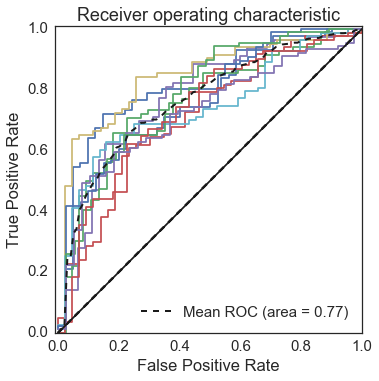

In [163]:
# plot the ROCs:
mt.plot_roc_curves_with_mean(y_tests, y_pred_probas)


In [164]:
# try to overlay this one and the mean plot..  

## Visualize the Parkinson's/non-Parkinson's split among key features:

First, look at the age distribution.

There is a wide difference in ages between Parkinson's and non-Parkinson's users, and all of the young peope are non-Parkinson's.  

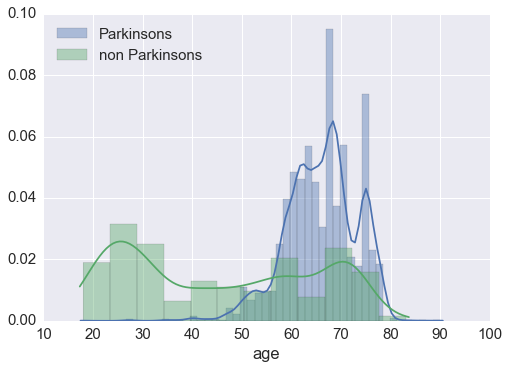

In [165]:
df_Parkinsons = data.loc[data['hasParkinsons']==True, :]
df_np = data.loc[data['hasParkinsons']==False, :]

distcol = 'age'
plt.figure()
sns.distplot(df_Parkinsons[distcol].dropna(), label='Parkinsons')
sns.distplot(df_np[distcol].dropna(), label='non Parkinsons')
plt.legend(loc=2)
pass

Because of this age imbalance, I cut out all of the users below the age of 45. This fixes a lot of problems that came in the early data analysis, when I was including these users. 


In [166]:
datasample = data[data['age']>agecutoff]
df_Parkinsons = datasample.loc[datasample['hasParkinsons']==True, :]
df_np = datasample.loc[datasample['hasParkinsons']==False, :]


Below is the new distribution of ages, after removing these younger users.

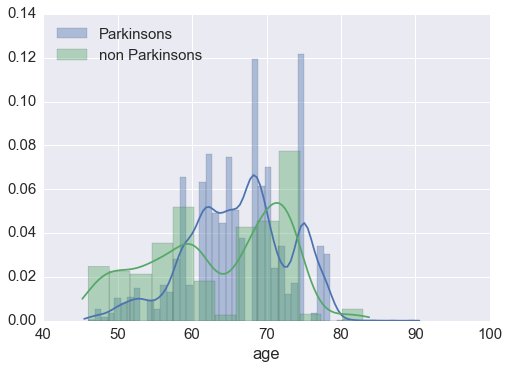

In [167]:
distcol = 'age'
plt.figure()
sns.distplot(df_Parkinsons[distcol].dropna(), label='Parkinsons')
sns.distplot(df_np[distcol].dropna(), label='non Parkinsons')
plt.legend(loc=2)

Now, I will look at various features, and how they differ between Parkinson's and non-Parkinson's patients.

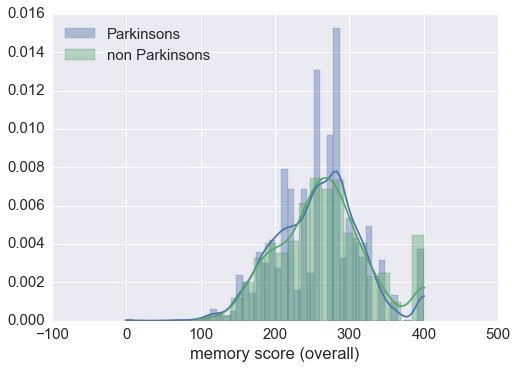

In [168]:
distcol = 'game_score'
plt.figure()
sns.distplot(df_Parkinsons[distcol].dropna(), label='Parkinsons')
sns.distplot(df_np[distcol].dropna(), label='non Parkinsons')
plt.xlabel(mt.feature_names([distcol])[0])
plt.legend(loc=2)

Note, game score is not, alone, differentiating between Parkinson's and non-Parkinson's. Let's look at the features that came up the highest importance in the logistic regression model:

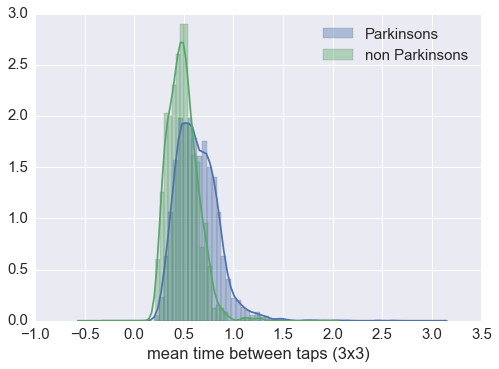

In [169]:
distcol = '9_meanDt'
plt.figure()
sns.distplot(df_Parkinsons[distcol].dropna(), label='Parkinsons')
sns.distplot(df_np[distcol].dropna(), label='non Parkinsons')
plt.xlabel(mt.feature_names([distcol])[0])
plt.legend(loc=1)

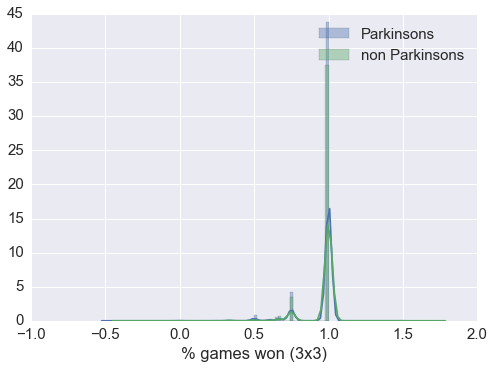

In [170]:
distcol = '9_successful'
plt.figure()
sns.distplot(df_Parkinsons[distcol].dropna(), label='Parkinsons')
sns.distplot(df_np[distcol].dropna(), label='non Parkinsons')
plt.xlabel(mt.feature_names([distcol])[0])
plt.legend(loc=1)

( this last one looks glitchy. Indeed, removing it and related features does not degrade performance of the predictor (see ROC plots above).

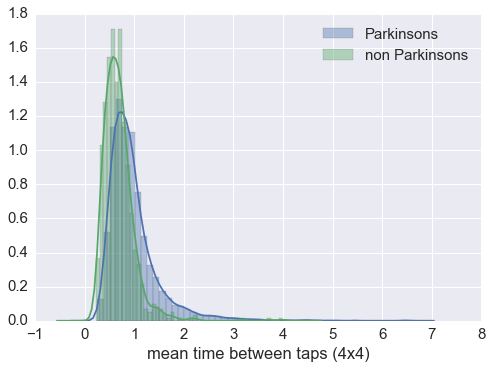

In [171]:
distcol = '16_meanDt'
plt.figure()
sns.distplot(df_Parkinsons[distcol].dropna(), label='Parkinsons')
sns.distplot(df_np[distcol].dropna(), label='non Parkinsons')
plt.xlabel(mt.feature_names([distcol])[0])
plt.legend(loc=1)

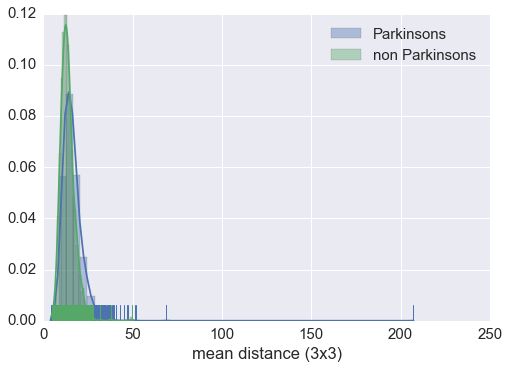

In [172]:
distcol = '9_meandist'
plt.figure()
sns.distplot(df_Parkinsons[distcol].dropna(), label='Parkinsons', rug=True)
sns.distplot(df_np[distcol].dropna(), label='non Parkinsons', rug=True)
plt.xlabel(mt.feature_names([distcol])[0])
plt.legend(loc=1)

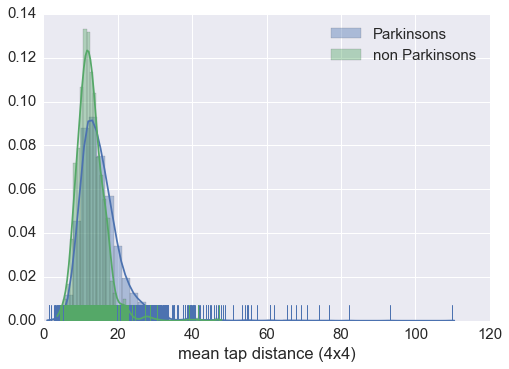

In [173]:
distcol = '16_meandist'
plt.figure()
sns.distplot(df_Parkinsons[distcol].dropna(), label='Parkinsons', rug=True)
sns.distplot(df_np[distcol].dropna(), label='non Parkinsons', rug=True)
plt.xlabel(mt.feature_names([distcol])[0])
plt.legend(loc=1)

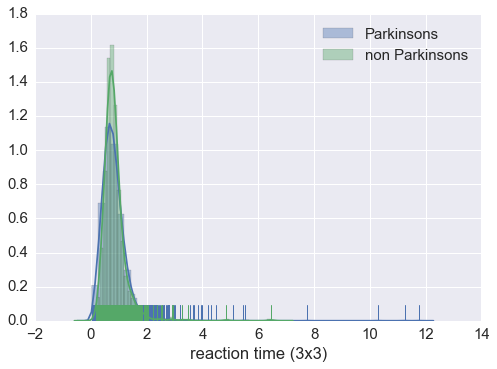

In [174]:
distcol = '9_latency'
plt.figure()
sns.distplot(df_Parkinsons[distcol].dropna(), label='Parkinsons', rug=True)
sns.distplot(df_np[distcol].dropna(), label='non Parkinsons', rug=True)
plt.xlabel(mt.feature_names([distcol])[0])
plt.legend(loc=1)
pass

I was surpised that the reaction time (i.e., the time before the first tap) didn't come up with very different distributions.  I've included a rug plot here, and you can see that the very long reaction times do tend to be Parkinson's patients - so it is still a useful feature. 